# Natural Language Processing Project : YELP

In this NLP project we will be attempting to classify Yelp Reviews into 1 star or 5 star categories based off the text content in the reviews.

**DATA SET :** [Yelp Review Data Set from Kaggle](https://www.kaggle.com/c/yelp-recsys-2013).

Each observation in this dataset is a review of a particular business by a particular user.

- The **stars** column is the number of stars (1 through 5) assigned by the reviewer to the business. (*Higher stars is better*).
- In other words, ***it is the rating of the business*** by the person who wrote the review.<br><br>

- The **cool** column is the number of "cool" votes this review received from other Yelp users. All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive.
- In other words, ***it is a rating of the review itself***, not a rating of the business.<br><br>

- The **useful** and **funny** columns are similar to the **cool** column.

Let's get started!

### Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')

%matplotlib inline

In [2]:
# import nltk

# nltk.download_shell()    # To download "stopwords"

In [3]:
import string

from nltk.corpus import stopwords

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, confusion_matrix

### Getting the data
___

* Reading the <code>yelp.csv</code> file

In [5]:
yelp_data = pd.read_csv('./yelp.csv')

** Check the head, info , and describe methods on yelp.**

In [6]:
yelp_data.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [7]:
yelp_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 11.1 MB


In [8]:
yelp_data.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


**Evaluating columns to remove the unimportant columns**

In [9]:
yelp_data['type'].value_counts()    # Same value throughout the dataset : NOT RELEVANT

review    10000
Name: type, dtype: int64

Also, columns **business_id, user_id, review_id, date** of a review are **IRRELEVANT** to our analysis

In [10]:
yelp = yelp_data[['text', 'stars', 'cool', 'useful', 'funny']]

yelp.head()

,text,stars,cool,useful,funny
0,My wife took me here on my birthday for breakf...,5,2,5,0
1,I have no idea why some people give bad review...,5,0,0,0
2,love the gyro plate. Rice is so good and I als...,4,0,1,0
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",5,1,2,0
4,General Manager Scott Petello is a good egg!!!...,5,0,0,0


**Creating a new column representing the text length for each review, labelled as "text_length"**

In [11]:
yelp['text_length'] = yelp['text'].apply(len)

yelp.head()

/tmp/ipykernel_29997/2815714269.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yelp['text_length'] = yelp['text'].apply(len)


,text,stars,cool,useful,funny,text_length
0,My wife took me here on my birthday for breakf...,5,2,5,0,889
1,I have no idea why some people give bad review...,5,0,0,0,1345
2,love the gyro plate. Rice is so good and I als...,4,0,1,0,76
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",5,1,2,0,419
4,General Manager Scott Petello is a good egg!!!...,5,0,0,0,469


# EDA
___

Let's explore the data

In [12]:
# Text Lengths for every star value

yelp.groupby('stars')['text_length'].describe().T

stars,1,2,3,4,5
count,749.000000,927.000000,1461.000000,3526.000000,3337.000000
mean,826.515354,842.256742,758.498289,712.923142,624.999101
std,742.929304,704.079491,627.594294,600.158476,558.578229
min,11.000000,7.000000,1.000000,2.000000,6.000000
25%,315.000000,365.500000,342.000000,307.000000,243.000000
50%,600.000000,656.000000,599.000000,551.500000,471.000000
75%,1075.000000,1105.000000,975.000000,945.750000,826.000000
max,4618.000000,4972.000000,4975.000000,4997.000000,4986.000000


<AxesSubplot:xlabel='stars', ylabel='count'>

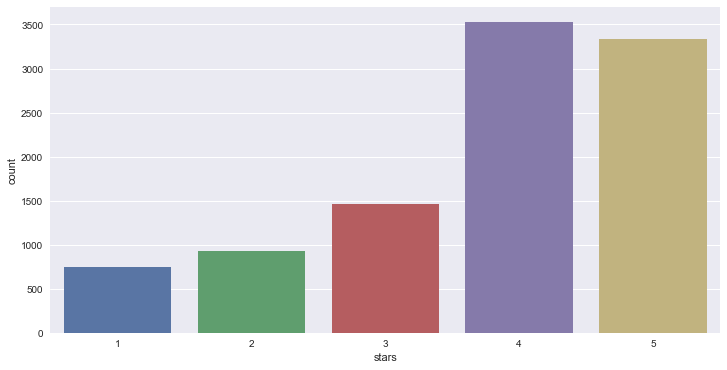

In [13]:
plt.figure(figsize=(12, 6))

sns.countplot(data=yelp, x='stars')

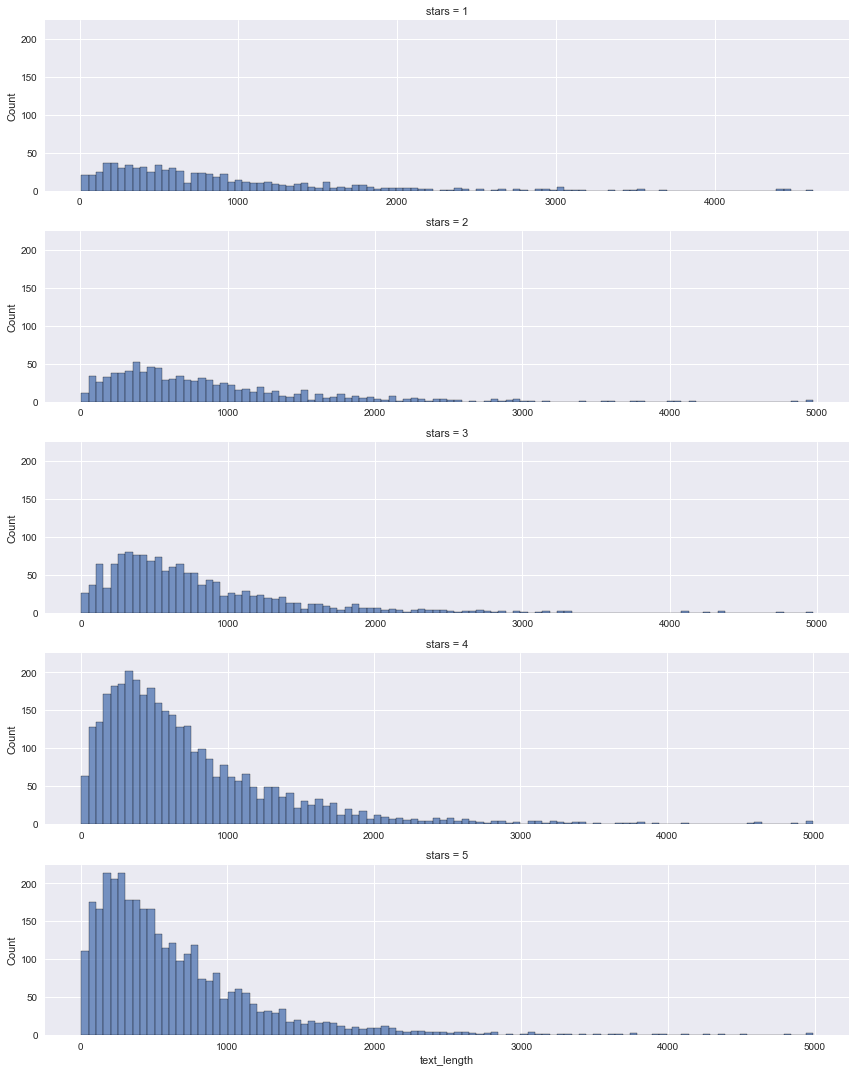

In [14]:
fg = sns.FacetGrid(data=yelp, row='stars', aspect=4, height=3, sharex=False)


fg.map(sns.histplot, 'text_length', bins=100)

<big>**OBSERVATION**:<br><br> While there is quite a variance in the quantity of reviews across different star values, **the distribution of text lengths seems to be quite similar for each star value**</big>

<AxesSubplot:xlabel='stars', ylabel='text_length'>

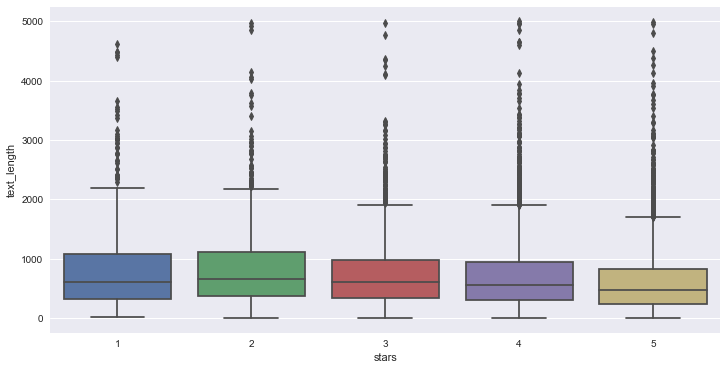

In [15]:
plt.figure(figsize=(12, 6))

sns.boxplot(data=yelp, x='stars', y='text_length')

**Let's explore correlations**

In [16]:
yelp.groupby('stars').mean()

,cool,useful,funny,text_length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


In [17]:
# Correlations

yelp.groupby('stars').mean().corr()

,cool,useful,funny,text_length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text_length,-0.857664,0.699881,0.843461,1.000000


<AxesSubplot:>

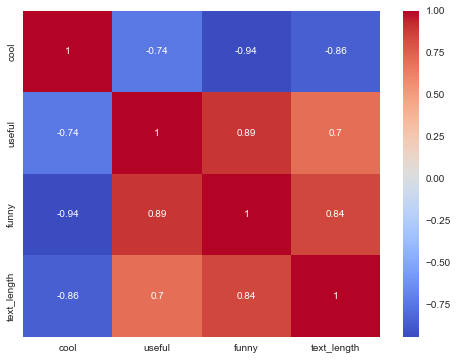

In [18]:
plt.figure(figsize=(8,6))

sns.heatmap(data=yelp.groupby('stars').mean().corr(),
            cmap="coolwarm", annot=True)

## NLP Classification Task
___

**TARGET** : Training a model to classify messages to 1 star or 5 star category
___

**Step 1** : Filter out only 1 and 5 star reviews from dataset

In [19]:
filter_ = (yelp['stars'] == 1) | (yelp['stars'] == 5)

yelp_filtered = yelp[filter_]

yelp_filtered['stars'].value_counts()

5    3337
1     749
Name: stars, dtype: int64

In [20]:
len(yelp_filtered)

4086

**Step 2** : Defining a function to clean and Tokenize the messages

In [21]:
def get_tokens(text):
    """
    Removes punctuations
    Removes common english words(low significance)
    Returns Keywords / Tokens (important words)
    """
    # Removing Punctuations
    text = "".join(ch for ch in text.strip() if ch not in string.punctuation)
    
    # Returning Tokens after removing low significance words
    return [word for word in text.split() if word.lower() not in stopwords.words('english')]

In [22]:
# testing our function on a sample message

get_tokens("I hope so.... I just want to say that it is important for me!!!!")

['hope', 'want', 'say', 'important']

**Step 3** : Creating a number of Pipelines with different options in order to find the optimum model

In [23]:
param_grid_NB = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10]}

In [24]:
# Option 1 : Multinomial Naive Bayes Classifier (without Tokenization and Normalization)

# Workflow steps:
    # 1. Create "Bag of Words" (BOW)
                            # (Matrix of Unique Words in the text Corpus Vs thier count in each message)
        
    # 2. Classification Model : Multinomial Naive Bayes classifier.

workflow = [('bow1', CountVectorizer(lowercase=False)),
            ('classifier1', GridSearchCV(MultinomialNB(), param_grid_NB, verbose=3))]

model_NB = Pipeline(workflow, verbose=True)

In [25]:
# Option 2 : Multinomial Naive Bayes Classifier with Tokenized Data (without Normalization)

# Workflow steps:
    # 1. Tokenize messages and Create "Bag of Words" (BOW)
                            # (Matrix of Unique Words in the text Corpus Vs thier count in each message)
        
    # 2. Classification Model : Multinomial Naive Bayes classifier.

workflow = [('bow2', CountVectorizer(analyzer=get_tokens, lowercase=False)),
            ('classifier2', GridSearchCV(MultinomialNB(), param_grid_NB, verbose=3))]

model_NB_token = Pipeline(workflow, verbose=True)

In [26]:
# Option 3 : Multinomial Naive Bayes Classifier with Tokenized and Normalized Data

# Workflow steps:
    # 1. Tokenize messages and Create "Bag of Words" (BOW)
                            # (Matrix of Unique Words in the text Corpus Vs thier count in each message)
        
    # 2. Normalized Vectorization of BOW, using TF-IDF Weighted Values
                            # TF : Term Frequency
                            # TF of word W = Count of W in a message / Total Words in the message
                            # IDF : Inverse Document Frequency
                            # IDF of term t = log_e(Total messages / Count of messages containing term t)
                    
    # 3. Classification Model : Multinomial Naive Bayes classifier.

workflow = [('bow3', CountVectorizer(analyzer=get_tokens, lowercase=False)),
            ('tfidf3', TfidfTransformer()),
            ('classifier3', GridSearchCV(MultinomialNB(), param_grid_NB, verbose=3))]

model_NB_token_norm = Pipeline(workflow, verbose=True)

In [27]:
param_grid_RF = {'n_jobs' : [1], 'n_estimators' : [25],
#                  'ccp_alpha' : [num/10 for num in range(1,11)],
                 'criterion' : ['gini', 'entropy'],
                 'bootstrap' : [True, False]}

In [28]:
# Option 4 : Random Forest Classifier (without Tokenization and Normalization)

# Workflow steps:
    # 1. Create "Bag of Words" (BOW)
                            # (Matrix of Unique Words in the text Corpus Vs thier count in each message)
        
    # 2. Classification Model : Random Forest classifier.

workflow = [('bow4', CountVectorizer(lowercase=False)),
            ('classifier4', GridSearchCV(RandomForestClassifier(), param_grid_RF, verbose=3))]

model_RF = Pipeline(workflow)

In [29]:
# Option 5 : Random Forest Classifier with Tokenized Data (without Normalization)

# Workflow steps:
    # 1. Tokenize messages and Create "Bag of Words" (BOW)
                            # (Matrix of Unique Words in the text Corpus Vs thier count in each message)
        
    # 2. Classification Model : Random Forest classifier.

workflow = [('bow5', CountVectorizer(analyzer=get_tokens, lowercase=False)),
            ('classifier5', GridSearchCV(RandomForestClassifier(), param_grid_RF, verbose=3))]

model_RF_token = Pipeline(workflow)

In [30]:
# Option 6 : Random Forest Classifier with Tokenized and Normalized Data

# Workflow steps:
    # 1. Tokenize messages and Create "Bag of Words" (BOW)
                            # (Matrix of Unique Words in the text Corpus Vs thier count in each message)
        
    # 2. Normalized Vectorization of BOW, using TF-IDF Weighted Values
                            # TF : Term Frequency
                            # TF of word W = Count of W in a message / Total Words in the message
                            # IDF : Inverse Document Frequency
                            # IDF of term t = log_e(Total messages / Count of messages containing term t)
                    
    # 3. Classification Model : Random Forest classifier.

workflow = [('bow6', CountVectorizer(analyzer=get_tokens, lowercase=False)),
            ('tfidf6', TfidfTransformer()),
            ('classifier6', GridSearchCV(RandomForestClassifier(), param_grid_RF, verbose=3))]

model_RF_token_norm = Pipeline(workflow)

**Step 4** : Train-Test Split

In [31]:
# Step 4 : Train Test Split

text_train, text_test, stars_train, stars_test = train_test_split(yelp_filtered['text'],
                                                                  yelp_filtered['stars'],
                                                                  test_size=0.25, random_state=101)

In [32]:
stars_train.value_counts()

5    2499
1     565
Name: stars, dtype: int64

**Step 5** : Train Classifier Models

In [33]:
model_NB.fit(text_train, stars_train)

model_NB_token.fit(text_train, stars_train)

model_NB_token_norm.fit(text_train, stars_train)

[Pipeline] .............. (step 1 of 2) Processing bow1, total=   0.5s
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ......................alpha=0.0001;, score=0.884 total time=   0.0s
[CV 2/5] END ......................alpha=0.0001;, score=0.886 total time=   0.0s
[CV 3/5] END ......................alpha=0.0001;, score=0.889 total time=   0.0s
[CV 4/5] END ......................alpha=0.0001;, score=0.891 total time=   0.0s
[CV 5/5] END ......................alpha=0.0001;, score=0.899 total time=   0.0s
[CV 1/5] END .......................alpha=0.001;, score=0.891 total time=   0.0s
[CV 2/5] END .......................alpha=0.001;, score=0.896 total time=   0.0s
[CV 3/5] END .......................alpha=0.001;, score=0.899 total time=   0.0s
[CV 4/5] END .......................alpha=0.001;, score=0.900 total time=   0.0s
[CV 5/5] END .......................alpha=0.001;, score=0.910 total time=   0.0s
[CV 1/5] END ........................alpha=0.01;, score=0.9

Pipeline(steps=[('bow3',
                 CountVectorizer(analyzer=<function get_tokens at 0x7fd085740e50>,
                                 lowercase=False)),
                ('tfidf3', TfidfTransformer()),
                ('classifier3',
                 GridSearchCV(estimator=MultinomialNB(),
                              param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1,
                                                    10]},
                              verbose=3))],
         verbose=True)

In [34]:
model_RF.fit(text_train, stars_train)

model_RF_token.fit(text_train, stars_train)

model_RF_token_norm.fit(text_train, stars_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END bootstrap=True, criterion=gini, n_estimators=25, n_jobs=1;, score=0.847 total time=   0.9s
[CV 2/5] END bootstrap=True, criterion=gini, n_estimators=25, n_jobs=1;, score=0.850 total time=   0.9s
[CV 3/5] END bootstrap=True, criterion=gini, n_estimators=25, n_jobs=1;, score=0.853 total time=   0.9s
[CV 4/5] END bootstrap=True, criterion=gini, n_estimators=25, n_jobs=1;, score=0.848 total time=   0.9s
[CV 5/5] END bootstrap=True, criterion=gini, n_estimators=25, n_jobs=1;, score=0.856 total time=   0.8s
[CV 1/5] END bootstrap=True, criterion=entropy, n_estimators=25, n_jobs=1;, score=0.837 total time=   0.7s
[CV 2/5] END bootstrap=True, criterion=entropy, n_estimators=25, n_jobs=1;, score=0.838 total time=   0.7s
[CV 3/5] END bootstrap=True, criterion=entropy, n_estimators=25, n_jobs=1;, score=0.838 total time=   0.7s
[CV 4/5] END bootstrap=True, criterion=entropy, n_estimators=25, n_jobs=1;, score=0.852 total time=

Pipeline(steps=[('bow6',
                 CountVectorizer(analyzer=<function get_tokens at 0x7fd085740e50>,
                                 lowercase=False)),
                ('tfidf6', TfidfTransformer()),
                ('classifier6',
                 GridSearchCV(estimator=RandomForestClassifier(),
                              param_grid={'bootstrap': [True, False],
                                          'criterion': ['gini', 'entropy'],
                                          'n_estimators': [25], 'n_jobs': [1]},
                              verbose=3))])

**Step 6** : Predict Values using Trained Models

In [35]:
pred_NB = model_NB.predict(text_test)

pred_NB_token = model_NB_token.predict(text_test)

pred_NB_token_norm = model_NB_token_norm.predict(text_test)

In [36]:
pred_RF = model_RF.predict(text_test)

pred_RF_token = model_RF_token.predict(text_test)

pred_RF_token_norm = model_RF_token_norm.predict(text_test)

**Step 7** : Evaluation of Models

In [37]:
# Model 1 : Multinomial Naive Bayes Classifier (without Tokenization and Normalization)

print(confusion_matrix(pred_NB, stars_test))
print()
print(classification_report(pred_NB, stars_test))

[[148  30]
 [ 36 808]]

              precision    recall  f1-score   support

           1       0.80      0.83      0.82       178
           5       0.96      0.96      0.96       844

    accuracy                           0.94      1022
   macro avg       0.88      0.89      0.89      1022
weighted avg       0.94      0.94      0.94      1022



In [38]:
# Model 2 : Multinomial Naive Bayes Classifier with Tokenized Data (without Normalization)

print(confusion_matrix(pred_NB_token, stars_test))
print()
print(classification_report(pred_NB_token, stars_test))

[[130  24]
 [ 54 814]]

              precision    recall  f1-score   support

           1       0.71      0.84      0.77       154
           5       0.97      0.94      0.95       868

    accuracy                           0.92      1022
   macro avg       0.84      0.89      0.86      1022
weighted avg       0.93      0.92      0.93      1022



In [39]:
# Model 3 : Multinomial Naive Bayes Classifier with Tokenized and Normalized Data

print(confusion_matrix(pred_NB_token_norm, stars_test))
print()
print(classification_report(pred_NB_token_norm, stars_test))

[[112  14]
 [ 72 824]]

              precision    recall  f1-score   support

           1       0.61      0.89      0.72       126
           5       0.98      0.92      0.95       896

    accuracy                           0.92      1022
   macro avg       0.80      0.90      0.84      1022
weighted avg       0.94      0.92      0.92      1022



In [40]:
# Model 4 : Random Forest Classifier (without Tokenization and Normalization)

print(confusion_matrix(pred_RF, stars_test))
print()
print(classification_report(pred_RF, stars_test))

[[ 38   4]
 [146 834]]

              precision    recall  f1-score   support

           1       0.21      0.90      0.34        42
           5       1.00      0.85      0.92       980

    accuracy                           0.85      1022
   macro avg       0.60      0.88      0.63      1022
weighted avg       0.96      0.85      0.89      1022



In [41]:
# Model 5 : Random Forest Classifier with Tokenized Data (without Normalization)

print(confusion_matrix(pred_RF_token, stars_test))
print()
print(classification_report(pred_RF_token, stars_test))

[[ 64   7]
 [120 831]]

              precision    recall  f1-score   support

           1       0.35      0.90      0.50        71
           5       0.99      0.87      0.93       951

    accuracy                           0.88      1022
   macro avg       0.67      0.89      0.72      1022
weighted avg       0.95      0.88      0.90      1022



In [42]:
# Model 6 : Random Forest Classifier with Tokenized and Normalized Data

print(confusion_matrix(pred_RF_token_norm, stars_test))
print()
print(classification_report(pred_RF_token_norm, stars_test))

[[ 50   2]
 [134 836]]

              precision    recall  f1-score   support

           1       0.27      0.96      0.42        52
           5       1.00      0.86      0.92       970

    accuracy                           0.87      1022
   macro avg       0.63      0.91      0.67      1022
weighted avg       0.96      0.87      0.90      1022



<big>**OBSERVATION** : Naive Bayes Classifier is more accurate than Random Forest Classifier for our Task</big>
___

<br>

<big>**FINAL STEP** : Tweaking the NB Models to find the most accurate model</big>

In [43]:
# Model 1 : Multinomial Naive Bayes Classifier (without Tokenization and Normalization)

workflow = [('bow1', CountVectorizer(lowercase=False)),
            ('classifier1', MultinomialNB(alpha=0.2))]

model_NB = Pipeline(workflow, verbose=True)

model_NB.fit(text_train, stars_train)

pred_NB = model_NB.predict(text_test)

print(confusion_matrix(pred_NB, stars_test))
print()
print(classification_report(pred_NB, stars_test))

[Pipeline] .............. (step 1 of 2) Processing bow1, total=   0.4s
[Pipeline] ....... (step 2 of 2) Processing classifier1, total=   0.0s
[[152  30]
 [ 32 808]]

              precision    recall  f1-score   support

           1       0.83      0.84      0.83       182
           5       0.96      0.96      0.96       840

    accuracy                           0.94      1022
   macro avg       0.90      0.90      0.90      1022
weighted avg       0.94      0.94      0.94      1022



In [44]:
# Model 2 : Multinomial Naive Bayes Classifier with Tokenization (without Normalization)

workflow = [('bow2', CountVectorizer(analyzer=get_tokens, lowercase=False)),
            ('classifier2',MultinomialNB(alpha=0.33))]

model_NB_token = Pipeline(workflow, verbose=True)

model_NB_token.fit(text_train, stars_train)

pred_NB_token = model_NB_token.predict(text_test)

print(confusion_matrix(pred_NB_token, stars_test))
print()
print(classification_report(pred_NB_token, stars_test))

[Pipeline] .............. (step 1 of 2) Processing bow2, total=  45.2s
[Pipeline] ....... (step 2 of 2) Processing classifier2, total=   0.0s
[[146  20]
 [ 38 818]]

              precision    recall  f1-score   support

           1       0.79      0.88      0.83       166
           5       0.98      0.96      0.97       856

    accuracy                           0.94      1022
   macro avg       0.88      0.92      0.90      1022
weighted avg       0.95      0.94      0.94      1022



In [45]:
# Model 3 : Multinomial Naive Bayes Classifier with Tokenization and Normalization

workflow = [('bow3', CountVectorizer(analyzer=get_tokens, lowercase=False)),
            ('tfidf3', TfidfTransformer()),
            ('classifier3', MultinomialNB(alpha=0.0115))]


model_NB_token_norm = Pipeline(workflow, verbose=True)

model_NB_token_norm.fit(text_train, stars_train)

pred_NB_token_norm = model_NB_token_norm.predict(text_test)

print(confusion_matrix(pred_NB_token_norm, stars_test))
print()
print(classification_report(pred_NB_token_norm, stars_test))

[Pipeline] .............. (step 1 of 3) Processing bow3, total=  40.7s
[Pipeline] ............ (step 2 of 3) Processing tfidf3, total=   0.0s
[Pipeline] ....... (step 3 of 3) Processing classifier3, total=   0.0s
[[114  14]
 [ 70 824]]

              precision    recall  f1-score   support

           1       0.62      0.89      0.73       128
           5       0.98      0.92      0.95       894

    accuracy                           0.92      1022
   macro avg       0.80      0.91      0.84      1022
weighted avg       0.94      0.92      0.92      1022



## Result
___

After all the analysis, the best model for the task stands out to be **Multinomial Naive Bayes Classifier without Tokenization or Normalization** <code>model_NB</code>. Not only it delivers the **best precision, best recall and best f1-score**, it also **performs the fastest** due to absence of any overheads as compared to other models.

In [46]:
# BEST MODEL : Multinomial Naive Bayes Classifier (without Tokenization and Normalization)

workflow = [('bow1', CountVectorizer(lowercase=False)),
            ('classifier1', MultinomialNB(alpha=0.2))]

model_NB = Pipeline(workflow, verbose=True)

model_NB.fit(text_train, stars_train)

pred_NB = model_NB.predict(text_test)

print(confusion_matrix(pred_NB, stars_test))
print()
print(classification_report(pred_NB, stars_test))

[Pipeline] .............. (step 1 of 2) Processing bow1, total=   0.5s
[Pipeline] ....... (step 2 of 2) Processing classifier1, total=   0.0s
[[152  30]
 [ 32 808]]

              precision    recall  f1-score   support

           1       0.83      0.84      0.83       182
           5       0.96      0.96      0.96       840

    accuracy                           0.94      1022
   macro avg       0.90      0.90      0.90      1022
weighted avg       0.94      0.94      0.94      1022



## Thank You!

### Ramandeep Singh : ramanchawla1290@gmail.com